# Contrastive Learning

## 1. Czym jest Contrastive Learning?

**Contrastive Learning** uczy sieć neuronową tworzyć reprezentacje (embeddingi), gdzie:
- **Podobne** przykłady są blisko siebie
- **Różne** przykłady są daleko od siebie

### Kluczowe pojęcia

| Pojęcie | Opis |
|---------|------|
| **Anchor** | Główna próbka |
| **Positive** | Próbka podobna do anchora (ta sama klasa) |
| **Negative** | Próbka różna od anchora (inna klasa) |

### Triplet Loss
Przykład prostej funkcji straty która może być użyta do uczenia contrastive learning:

$$L = \max(d(a, p) - d(a, n) + \text{margin}, 0)$$

Cel: odległość anchor-negative powinna być większa niż anchor-positive o co najmniej `margin`.

## 2. Instalacja i import

Podejście **semi-supervised**: sieć uczy się reprezentacji na **danych bez etykiet** (self-supervised pretraining metodą SimCLR), a następnie ewaluujemy jakość embeddingów na **danych z etykietami** (linear probe).

instalacja pakietów: `pip install -r requirements.txt`

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import copy

from pytorch_metric_learning import losses

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używam: {device}")

Używam: cuda


## 3. Dane - CIFAR-10

### Przygotowanie danych semi-supervised:
1. **Dane bez etykiet (unlabeled)** - kopia CIFAR-10 z usuniętymi etykietami, używana do self-supervised pretrainingu
2. **Dane z etykietami (labeled)** - oryginalny zbiór testowy CIFAR-10, używany do ewaluacji jakości embeddingów

Dla każdego obrazu z danych unlabeled tworzymy **dwie augmentowane wersje** (widoki). Sieć uczy się, że oba widoki tego samego obrazu powinny mieć podobne embeddingi.

In [ ]:
# Silne augmentacje tworzące dwa różne "widoki" tego samego obrazu
simclr_augment = T.Compose([
    T.RandomResizedCrop(32, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply([T.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    T.RandomGrayscale(p=0.2),
    T.RandomRotation(15),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Prosta transformacja do ewaluacji (bez augmentacji)
eval_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


class UnlabeledContrastiveDataset(Dataset):
    """
    Kopia CIFAR-10 z usuniętymi etykietami.
    Zwraca dwa augmentowane widoki tego samego obrazu + umowną etykietę (indeks).
    """
    def __init__(self, cifar_dataset, transform):

        # Kopiujemy same obrazy, usuwamy etykiety
        self.images = [cifar_dataset[i][0] for i in range(len(cifar_dataset))]
        self.pil_images = []

        for i in range(len(cifar_dataset)):
            self.pil_images.append(cifar_dataset.data[i])
        self.transform = transform

    def __len__(self):
        return len(self.pil_images)

    def __getitem__(self, idx):
        from PIL import Image
        img = Image.fromarray(self.pil_images[idx])

        # Dwa różne augmentowane widoki tego samego obrazu
        view1 = self.transform(img)
        view2 = self.transform(img)

        # Umowna etykieta = indeks obrazu (positive pair ma tę samą etykietę)
        return view1, view2, idx


# Surowy CIFAR-10 (do skopiowania bez etykiet)
raw_trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True
)

# Dane bez etykiet - kopia z usuniętymi etykietami (5000 próbek dla szybkości)
raw_subset = torch.utils.data.Subset(raw_trainset, range(5000))
class SubsetWithData:
    def __init__(self, dataset, indices):
        self.data = dataset.data[indices]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], -1  # brak etykiety

subset_data = SubsetWithData(raw_trainset, list(range(5000)))
unlabeled_dataset = UnlabeledContrastiveDataset(subset_data, simclr_augment)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=256, shuffle=True, num_workers=2, drop_last=True)

# Dane z etykietami - zbiór testowy do ewaluacji
labeled_testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=eval_transform
)
labeled_loader = DataLoader(labeled_testset, batch_size=256, shuffle=False, num_workers=2)

# Etykietowany subset treningowy do treningu linear probe
labeled_trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=eval_transform
)
labeled_trainset = torch.utils.data.Subset(labeled_trainset, range(5000))
labeled_train_loader = DataLoader(labeled_trainset, batch_size=256, shuffle=True, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Dane bez etykiet (pretraining): {len(unlabeled_dataset)} próbek")
print(f"Dane z etykietami (ewaluacja train): {len(labeled_trainset)} próbek")
print(f"Dane z etykietami (ewaluacja test): {len(labeled_testset)} próbek")

/home/vantom/Col/AIPO/proj/venv/lib/python3.13/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Dane bez etykiet (pretraining): 5000 próbek
Dane z etykietami (ewaluacja train): 5000 próbek
Dane z etykietami (ewaluacja test): 10000 próbek


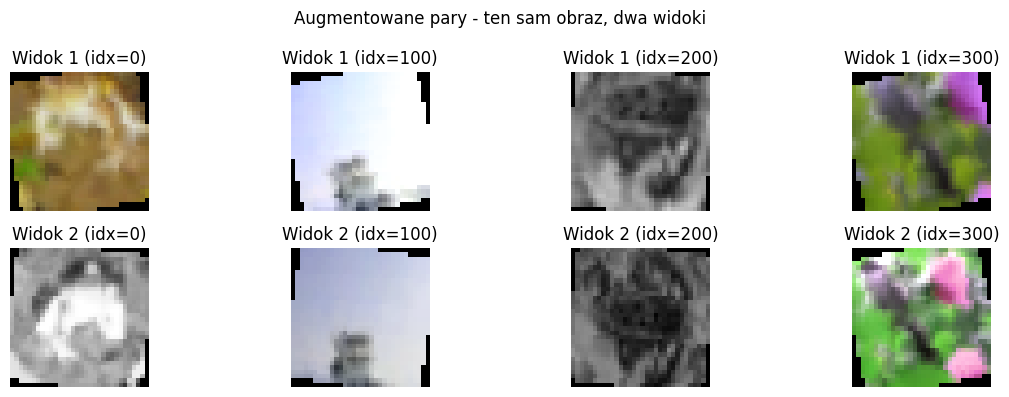

In [33]:
# Podgląd augmentowanych par (dwa widoki tego samego obrazu)
def show_augmented_pairs(dataset, n=4):
    fig, axes = plt.subplots(2, n, figsize=(12, 4))
    for i in range(n):
        view1, view2, idx = dataset[i * 100]
        for row, view, label in [(0, view1, "Widok 1"), (1, view2, "Widok 2")]:
            img = view.permute(1, 2, 0).numpy() * 0.5 + 0.5
            img = np.clip(img, 0, 1)
            axes[row][i].imshow(img)
            axes[row][i].set_title(f'{label} (idx={idx})')
            axes[row][i].axis('off')
    plt.suptitle('Augmentowane pary - ten sam obraz, dwa widoki', fontsize=12)
    plt.tight_layout()
    plt.show()

show_augmented_pairs(unlabeled_dataset)

## 4. Model - Encoder + Projection Head (SimCLR)

Architektura SimCLR składa się z:
1. **Encoder** (backbone) - sieć konwolucyjna produkująca reprezentacje
2. **Projection Head** - MLP mapujący reprezentacje do przestrzeni, w której obliczamy contrastive loss

Po pretreningu odrzucamy projection head i używamy samego encodera.

In [34]:
class SimCLRModel(nn.Module):
    """SimCLR: Encoder CNN + Projection Head MLP"""

    def __init__(self, embedding_dim=128, projection_dim=64):
        super().__init__()

        # Encoder (backbone)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        # Warstwa do embeddingu (część encodera)
        self.fc = nn.Linear(128, embedding_dim)

        # Projection head (używany tylko podczas pretreningu SimCLR)
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, projection_dim)
        )

    def get_embedding(self, x):
        """Zwraca embedding (bez projection head) - do ewaluacji"""
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return nn.functional.normalize(x, p=2, dim=1)

    def forward(self, x):
        """Zwraca projection (do contrastive loss podczas pretreningu)"""
        embedding = self.get_embedding(x)
        projection = self.projection(embedding)
        return nn.functional.normalize(projection, p=2, dim=1)


model = SimCLRModel(embedding_dim=128, projection_dim=64).to(device)
print(f"Parametry modelu: {sum(p.numel() for p in model.parameters()):,}")

Parametry modelu: 134,976


## 5. Self-Supervised Pretraining (SimCLR)

Trening **bez etykiet**: dla każdego obrazu tworzymy dwa augmentowane widoki. Sieć uczy się, że widoki tego samego obrazu (positive pair) powinny mieć podobne embeddingi, a widoki różnych obrazów (negative pairs) - odległe.

**NTXentLoss** (Normalized Temperature-scaled Cross Entropy Loss) to funkcja straty SimCLR:

$$\ell_{i,j} = -\log \frac{\exp(\text{sim}(z_i, z_j) / \tau)}{\sum_{k=1}^{2N} \mathbf{1}_{[k \neq i]} \exp(\text{sim}(z_i, z_k) / \tau)}$$

gdzie $\tau$ to parametr temperatury, a $\text{sim}$ to podobieństwo cosinusowe.

In [ ]:
# NTXentLoss - funkcja straty SimCLR
loss_fn = losses.NTXentLoss(temperature=0.5)

# Optimizer z weight decay (regularyzacja)
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)

In [ ]:
def train_simclr_epoch(model, loader, loss_fn, optimizer):
    """Jedna epoka self-supervised pretreningu SimCLR"""
    model.train()
    total_loss = 0

    for view1, view2, indices in loader:
        view1, view2 = view1.to(device), view2.to(device)

        optimizer.zero_grad()

        # Projekcje obu widoków
        z1 = model(view1)
        z2 = model(view2)

        embeddings = torch.cat([z1, z2], dim=0)
        labels = torch.cat([indices, indices], dim=0).to(device)

        loss = loss_fn(embeddings, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [37]:
# Self-supervised pretraining
epochs = 50
history = []

print("Rozpoczynam self-supervised pretraining (SimCLR)...")
print("Sieć uczy się BEZ etykiet - tylko z augmentowanych par obrazów\n")

torch.cuda.empty_cache()

for epoch in range(epochs):
    loss = train_simclr_epoch(model, unlabeled_loader, loss_fn, optimizer)
    history.append(loss)
    print(f"Epoch {epoch+1}/{epochs} | Contrastive Loss: {loss:.4f}")

print("\nPretraining zakończony!")

Rozpoczynam self-supervised pretraining (SimCLR)...
Sieć uczy się BEZ etykiet - tylko z augmentowanych par obrazów

Epoch 1/50 | Contrastive Loss: 5.9822
Epoch 2/50 | Contrastive Loss: 5.6888
Epoch 3/50 | Contrastive Loss: 5.5554
Epoch 4/50 | Contrastive Loss: 5.4568
Epoch 5/50 | Contrastive Loss: 5.3742
Epoch 6/50 | Contrastive Loss: 5.3692
Epoch 7/50 | Contrastive Loss: 5.3350
Epoch 8/50 | Contrastive Loss: 5.2907
Epoch 9/50 | Contrastive Loss: 5.2741
Epoch 10/50 | Contrastive Loss: 5.2581
Epoch 11/50 | Contrastive Loss: 5.2499
Epoch 12/50 | Contrastive Loss: 5.2358
Epoch 13/50 | Contrastive Loss: 5.2324
Epoch 14/50 | Contrastive Loss: 5.2091
Epoch 15/50 | Contrastive Loss: 5.2060
Epoch 16/50 | Contrastive Loss: 5.2006
Epoch 17/50 | Contrastive Loss: 5.2063
Epoch 18/50 | Contrastive Loss: 5.1942
Epoch 19/50 | Contrastive Loss: 5.1689
Epoch 20/50 | Contrastive Loss: 5.1635
Epoch 21/50 | Contrastive Loss: 5.1755
Epoch 22/50 | Contrastive Loss: 5.1626
Epoch 23/50 | Contrastive Loss: 5.1

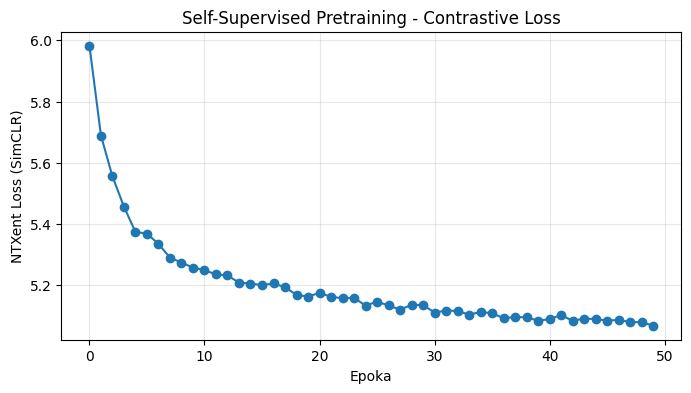

In [38]:
# Wykres straty
plt.figure(figsize=(8, 4))
plt.plot(history, marker='o')
plt.xlabel('Epoka')
plt.ylabel('NTXent Loss (SimCLR)')
plt.title('Self-Supervised Pretraining - Contrastive Loss')
plt.grid(True, alpha=0.3)
plt.show()

## 6. Ewaluacja - Linear Probe

Sprawdzamy jakość nauczonych reprezentacji: **zamrażamy encoder** i trenujemy prosty klasyfikator liniowy na **danych z etykietami**. Jeśli encoder nauczył się dobrych reprezentacji, nawet prosty klasyfikator powinien osiągnąć przyzwoitą dokładność.

In [39]:
@torch.no_grad()
def extract_features(model, loader):
    """Wyciągnij embeddingi z zamrożonego encodera"""
    model.eval()
    features, labels = [], []
    for images, batch_labels in loader:
        images = images.to(device)
        emb = model.get_embedding(images)
        features.append(emb.cpu())
        labels.append(batch_labels)
    return torch.cat(features), torch.cat(labels)


# Ekstrakcja cech z zamrożonego encodera
train_features, train_labels = extract_features(model, labeled_train_loader)
test_features, test_labels = extract_features(model, labeled_loader)

print(f"Cechy treningowe: {train_features.shape}")
print(f"Cechy testowe: {test_features.shape}")

Cechy treningowe: torch.Size([5000, 128])
Cechy testowe: torch.Size([10000, 128])


In [40]:
# Linear Probe - prosty klasyfikator liniowy na zamrożonych embeddingach
class LinearProbe(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)


probe = LinearProbe(128, 10).to(device)
probe_optimizer = optim.Adam(probe.parameters(), lr=1e-3)
probe_criterion = nn.CrossEntropyLoss()

# Trening linear probe
probe_epochs = 50
train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
probe_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

print("Trening Linear Probe na danych z etykietami...")
for epoch in range(probe_epochs):
    probe.train()
    for feats, lbls in probe_loader:
        feats, lbls = feats.to(device), lbls.to(device)
        probe_optimizer.zero_grad()
        logits = probe(feats)
        loss = probe_criterion(logits, lbls)
        loss.backward()
        probe_optimizer.step()

# Ewaluacja na zbiorze testowym
probe.eval()
with torch.no_grad():
    test_logits = probe(test_features.to(device))
    predictions = test_logits.argmax(dim=1).cpu()
    accuracy = (predictions == test_labels).float().mean().item()

print(f"\nDokładność Linear Probe na zbiorze testowym: {accuracy:.1%}")
print("(Losowe zgadywanie = 10% dla 10 klas)")

Trening Linear Probe na danych z etykietami...

Dokładność Linear Probe na zbiorze testowym: 41.9%
(Losowe zgadywanie = 10% dla 10 klas)


## 7. Wizualizacja embeddingów

Użyjemy t-SNE do redukcji wymiarów i zobaczenia czy klasy się separują - mimo że sieć nigdy nie widziała etykiet podczas pretreningu.

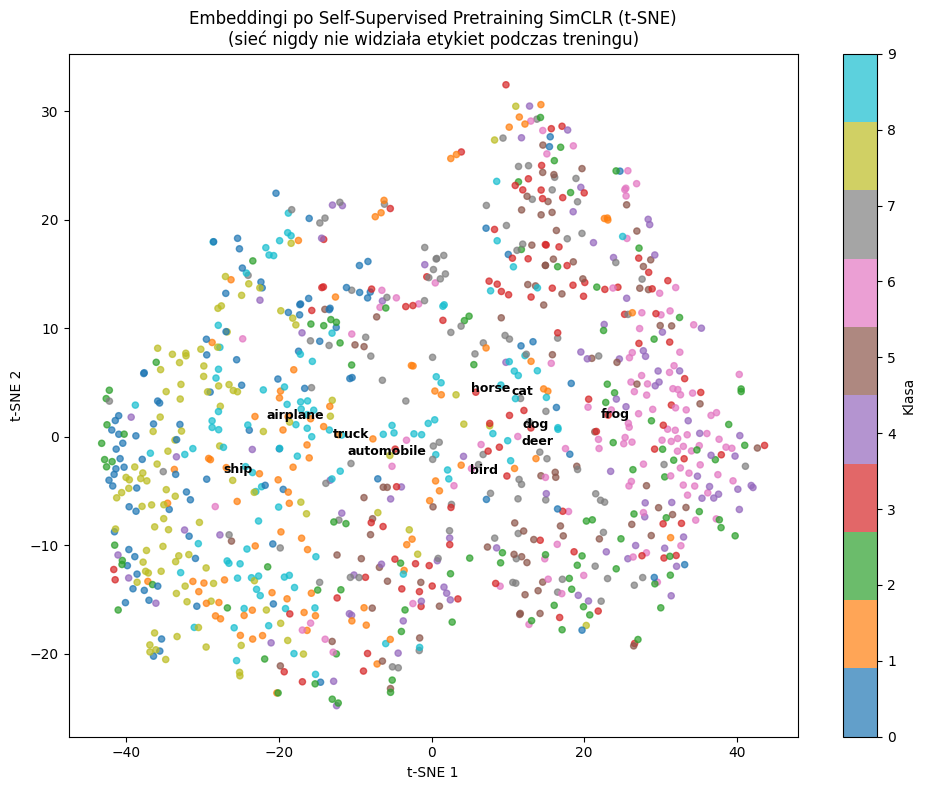

In [41]:
from sklearn.manifold import TSNE

# Używamy testowych embeddingów (mają etykiety do kolorowania)
sample_features = test_features[:1000].numpy()
sample_labels = test_labels[:1000].numpy()

# t-SNE redukcja do 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(sample_features)

# Wizualizacja
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=sample_labels, cmap='tab10', s=20, alpha=0.7
)
plt.colorbar(scatter, ticks=range(10), label='Klasa')
plt.title('Embeddingi po Self-Supervised Pretraining SimCLR (t-SNE)\n'
          '(sieć nigdy nie widziała etykiet podczas treningu)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

for i, name in enumerate(classes):
    mask = sample_labels == i
    if mask.any():
        plt.annotate(name, embeddings_2d[mask].mean(axis=0), fontsize=9, weight='bold')

plt.tight_layout()
plt.show()

## 8. Wyszukiwanie podobnych obrazów (Retrieval)

Praktyczne zastosowanie - znajdowanie podobnych obrazów na podstawie embeddingów nauczonych bez etykiet.

In [42]:
@torch.no_grad()
def find_similar(model, query_img, embeddings_db, k=5):
    """Znajdź k najbardziej podobnych obrazów"""
    model.eval()
    query_emb = model.get_embedding(query_img.unsqueeze(0).to(device))
    similarities = torch.mm(query_emb, embeddings_db.T).squeeze()
    top_k = similarities.topk(k)
    return top_k.indices, top_k.values


# Baza danych embeddingów (zbiór testowy)
db_embeddings = test_features.to(device)
db_labels = test_labels

# Surowe obrazy do wyświetlenia
db_images = []
for img, _ in torch.utils.data.Subset(labeled_testset, range(len(test_labels))):
    db_images.append(img)
db_images = torch.stack(db_images)

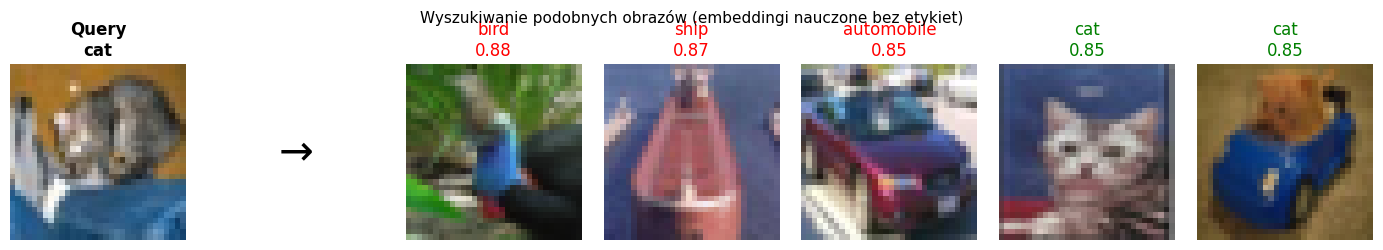

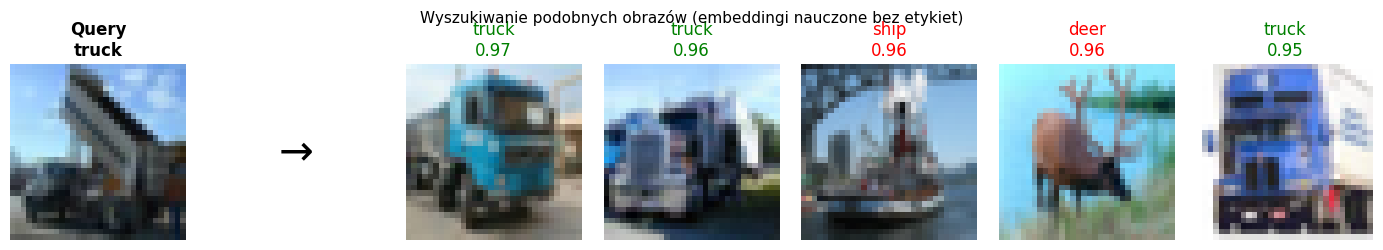

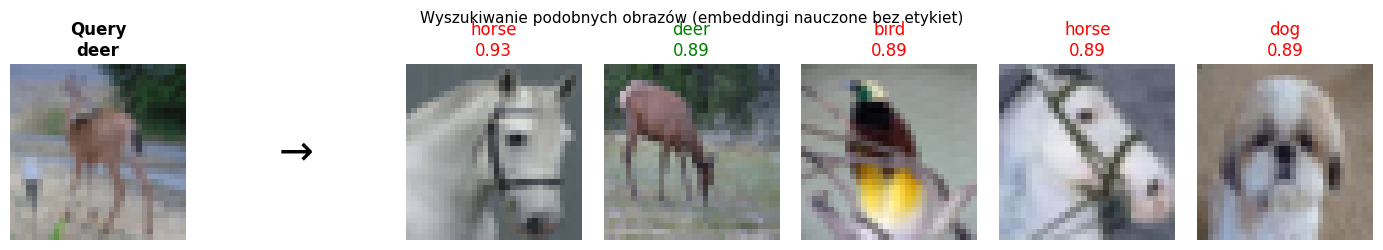

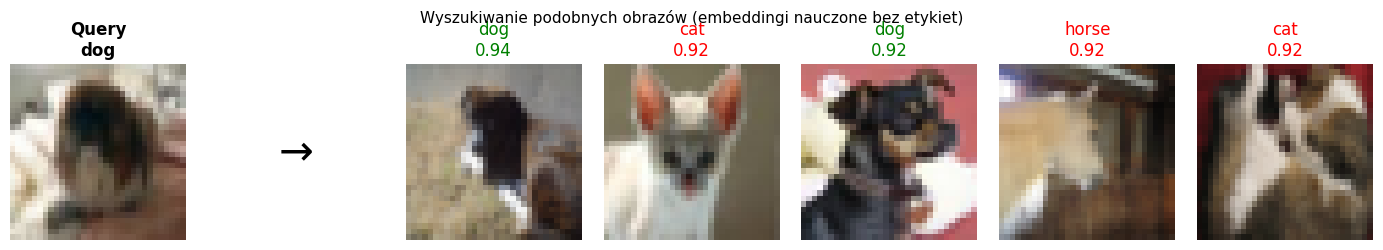

In [43]:
def show_retrieval(query_idx, k=5):
    """Pokaż wyniki wyszukiwania"""
    query_img = db_images[query_idx]
    query_label = db_labels[query_idx].item()

    indices, scores = find_similar(model, query_img, db_embeddings, k=k+1)

    fig, axes = plt.subplots(1, k+2, figsize=(14, 2.5))

    # Query
    img = query_img.permute(1, 2, 0).numpy() * 0.5 + 0.5
    axes[0].imshow(np.clip(img, 0, 1))
    axes[0].set_title(f'Query\n{classes[query_label]}', fontweight='bold')
    axes[0].axis('off')

    axes[1].text(0.5, 0.5, '\u2192', fontsize=30, ha='center', va='center')
    axes[1].axis('off')

    result_idx = 0
    for idx, score in zip(indices, scores):
        if idx == query_idx:
            continue
        if result_idx >= k:
            break
        img = db_images[idx].permute(1, 2, 0).numpy() * 0.5 + 0.5
        result_label = db_labels[idx].item()
        axes[result_idx + 2].imshow(np.clip(img, 0, 1))
        color = 'green' if result_label == query_label else 'red'
        axes[result_idx + 2].set_title(f'{classes[result_label]}\n{score:.2f}', color=color)
        axes[result_idx + 2].axis('off')
        result_idx += 1

    plt.suptitle('Wyszukiwanie podobnych obrazów (embeddingi nauczone bez etykiet)', fontsize=11)
    plt.tight_layout()
    plt.show()

for query_idx in [0, 50, 100, 200]:
    show_retrieval(query_idx, k=5)

## 9. Macierz konfuzji

Szczegółowa ewaluacja: które klasy sieć rozróżnia dobrze, a które myli.

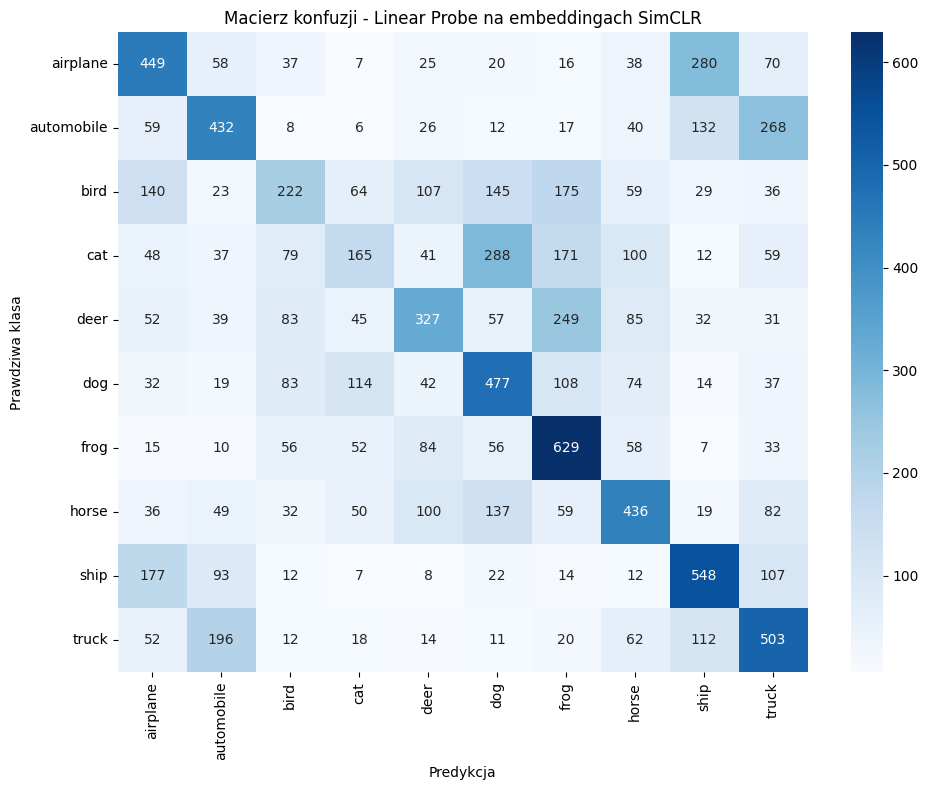

              precision    recall  f1-score   support

    airplane       0.42      0.45      0.44      1000
  automobile       0.45      0.43      0.44      1000
        bird       0.36      0.22      0.27      1000
         cat       0.31      0.17      0.22      1000
        deer       0.42      0.33      0.37      1000
         dog       0.39      0.48      0.43      1000
        frog       0.43      0.63      0.51      1000
       horse       0.45      0.44      0.44      1000
        ship       0.46      0.55      0.50      1000
       truck       0.41      0.50      0.45      1000

    accuracy                           0.42     10000
   macro avg       0.41      0.42      0.41     10000
weighted avg       0.41      0.42      0.41     10000



In [44]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(test_labels.numpy(), predictions.numpy())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predykcja')
plt.ylabel('Prawdziwa klasa')
plt.title('Macierz konfuzji - Linear Probe na embeddingach SimCLR')
plt.tight_layout()
plt.show()

print(classification_report(test_labels.numpy(), predictions.numpy(),
                            target_names=classes))

## 10. Podsumowanie

Semi-Suprevised learning jest przydatnym nażędziem, szczególnie tam gdzie dane są tylko częściowo oznaczone, lub całkowicie nie oznaczone. Contrastive learning znajduje swoje zastosowanie w wielu dzidzinach. Dzięki swojej odporności na augmentacje, jest świetnym nażędziem do wyszukiwania podobnych obrazów, sprawdzania plagiatów graficznych, czy rozpoznawaniu zdjęć osób pod różnym kątem. Sposób ten jest również wysoce odporny na szum przy danych wejściowych.

### Podejście semi-supervised z SimCLR:

| Etap | Dane | Etykiety | Cel |
|------|------|----------|-----|
| **Pretraining** | CIFAR-10 (kopia bez etykiet) | Brak (umowne indeksy par) | Nauka reprezentacji |
| **Linear Probe** | CIFAR-10 (z etykietami) | Tak | Ewaluacja jakości embeddingów |

### Kluczowe elementy:
1. **Dane bez etykiet** - kopia CIFAR-10 z usuniętymi prawdziwymi etykietami
2. **Augmentacje** - rotacja, zmiana kolorów, przycięcie, odbicie - tworzą pary positive
3. **NTXentLoss** - contrastive loss z SimCLR, uczy separacji w przestrzeni embeddingów
4. **Linear Probe** - prosty klasyfikator na zamrożonych embeddingach weryfikuje jakość reprezentacji

## 11. Zadania

### Zadanie 1: Zmień temperaturę
Zmień parametr `temperature` w `NTXentLoss` z `0.5` na `0.1` i ponownie wytrenuj model. Porównaj wykres straty i dokładność linear probe. Czy niższa temperatura poprawia wyniki?

### Zadanie 2: Usuń jedną augmentację
Usuń `ColorJitter` z pipeline'u augmentacji `simclr_augment` i wytrenuj model od nowa. Jak wpływa to na jakość embeddingów (t-SNE) i dokładność? Spróbuj też usunąć `RandomResizedCrop` - która augmentacja jest ważniejsza?

### Zadanie 3: Zwiększ liczbę danych treningowych
Zmień `range(5000)` na `range(20000)` w `SubsetWithData` i `labeled_trainset`. Wytrenuj model i porównaj dokładność. Czy 4x więcej danych bez etykiet daje proporcjonalnie lepsze wyniki?

### Zadanie 4: Dodaj GaussianBlur do augmentacji
Dodaj `T.GaussianBlur(kernel_size=3)` z prawdopodobieństwem `p=0.5` do pipeline'u augmentacji (użyj `T.RandomApply`). Wytrenuj model i sprawdź czy dodatkowa augmentacja poprawia reprezentacje.

### Zadanie 5: Porównaj z losowym encoderem
Stwórz nową instancję `SimCLRModel` **bez treningu** i przeprowadź na niej linear probe (sekcja 6). Porównaj dokładność losowego encodera z wytrenowanym - jaka jest różnica? To pokazuje ile "wiedzy" sieć zdobyła podczas self-supervised pretreningu.

In [45]:
# Miejsce na rozwiązania zadań
# ...